In [1]:
"""
overlap-save frequency domain GSC
refer to
    Efficient frequency-domain realization of robust generalized, sidelobe cancellers
Author:
    Wang Wei
"""
import argparse
from time import time

import numpy as np
from scipy.signal import windows

from DistantSpeech.adaptivefilter.FastFreqLms import FastFreqLms
from DistantSpeech.beamformer.MicArray import MicArray
from DistantSpeech.beamformer.beamformer import beamformer
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.beamformer.utils import visual
from DistantSpeech.transform.transform import Transform
from DistantSpeech.noise_estimation import McSpp
from DistantSpeech.beamformer.FDGSC import FDGSC, DelayObj

import librosa
import matplotlib.pyplot as plt
from DistantSpeech.transform.transform import Transform
from DistantSpeech.beamformer.utils import pmesh, mesh, load_wav, save_audio, load_pcm, pt
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.beamformer.beamformer import beamformer
from DistantSpeech.beamformer.MicArray import MicArray, compute_tau
from DistantSpeech.noise_estimation import McSpp

from pesq import pesq
from pystoi.stoi import stoi

The RT60 is 114 ms
(6, 316761)
(257, 1237, 6)


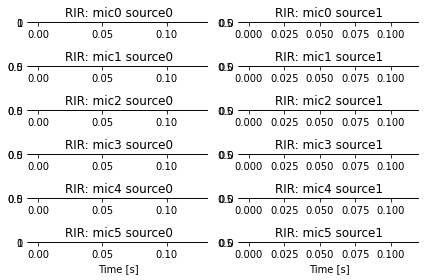

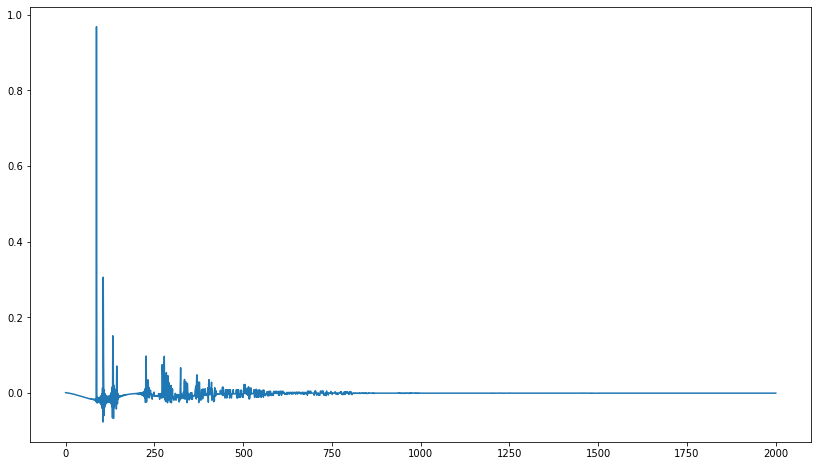

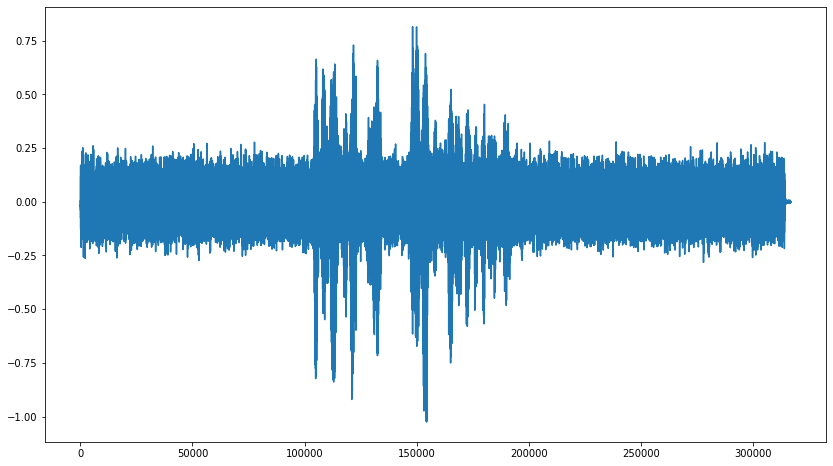

In [2]:
sampling_frequency = 16000
fft_length = 512
fft_shift = 256
mic_diameter = 0.1
sound_speed = 343
look_direction = 90
interf_angle = 135

signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/5_541_20170608093550_3.wav")
# signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3.wav")
noise = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office3.wav")

# signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/5_541_20170608093550_4.wav")
# # signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3.wav")
# noise = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office3.wav")

fs = 16000
M = 6
mic_array = MicArray(arrayType="linear", r=mic_diameter/2, M=M, n_fft=512)
mic_array_sim = mic_array.array_sim
# print(mic_array_sim.R)
array_data, premix = mic_array_sim.generate_audio(signal, interference=noise, source_angle=look_direction, interf_angle=interf_angle, sir=0, snr=30, source_distance=1.0, interf_distance=1.0)
theoretical=True
# audiowrite('mix.wav', np.transpose(array_data))
# audiowrite('signal.wav', np.transpose(premix[0, :, :]))
# audiowrite('interf.wav', np.transpose(premix[1, :, :]))

print(array_data.shape)
M = array_data.shape[0]
transform = Transform(n_fft=512, hop_length=256, channel=M)
D = transform.stft(np.transpose(array_data))
# transform = Transform(n_fft=512, hop_length=256, channel=M)
# target = transform.stft(np.transpose(premix[0, :M, :]))
# transform = Transform(n_fft=512, hop_length=256, channel=M)
# Noise = transform.stft(np.transpose(premix[1, :M, :]))
# print(Noise.shape)
half_bin = D.shape[0]
frame_num = D.shape[1]
print(D.shape)
plt.figure(figsize=(14,8))
plt.plot(mic_array_sim.room.rir[0][0])
plt.show()
# array_data = array_data[:, :160000]
pt(array_data[0, :])

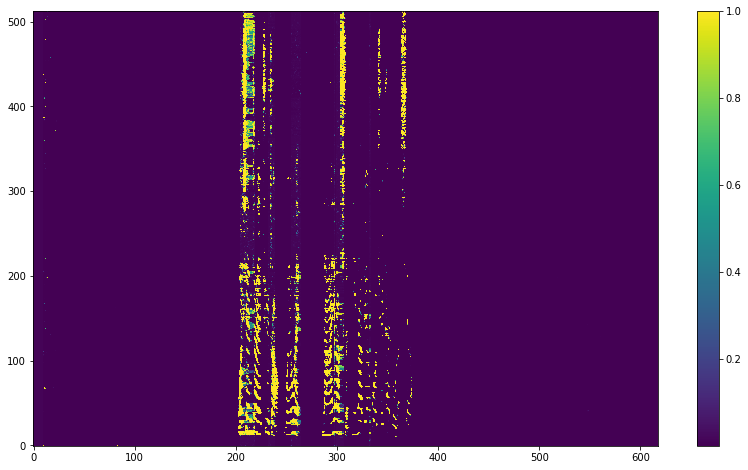

(316761,)


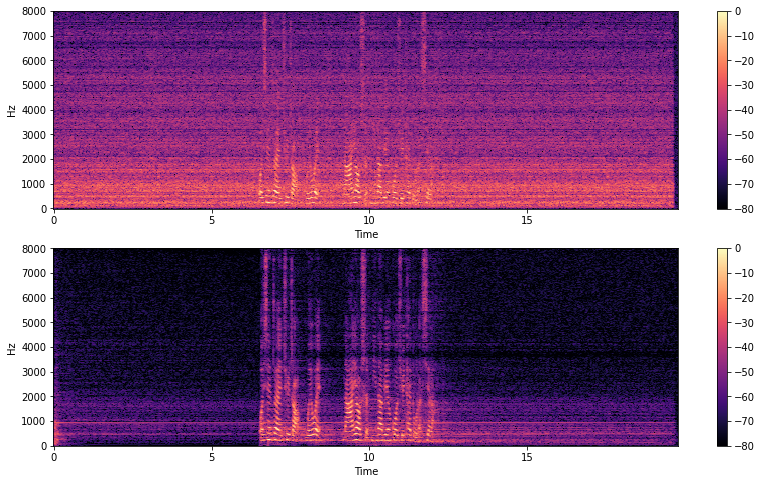

In [3]:
frameLen = 512
# hop = frameLen / 2
# overlap = frameLen - hop
# nfft = frameLen*2
# c = 340
# r = 0.032
# fs = 16000

# start = tim


start = time()

fdgsc = FDGSC(mic_array, frameLen=frameLen)

yout, p = fdgsc.process(array_data)
pmesh(p)
print(yout.shape)

# audiowrite('wav/out_aic.wav', yout)

# end = time()
# print(end - start)

visual(array_data[0, :], yout)


In [4]:
print(p.shape)
audiowrite('array_data_0.wav',array_data[0, :])
audiowrite('out_aic.wav', yout)

(513, 618)


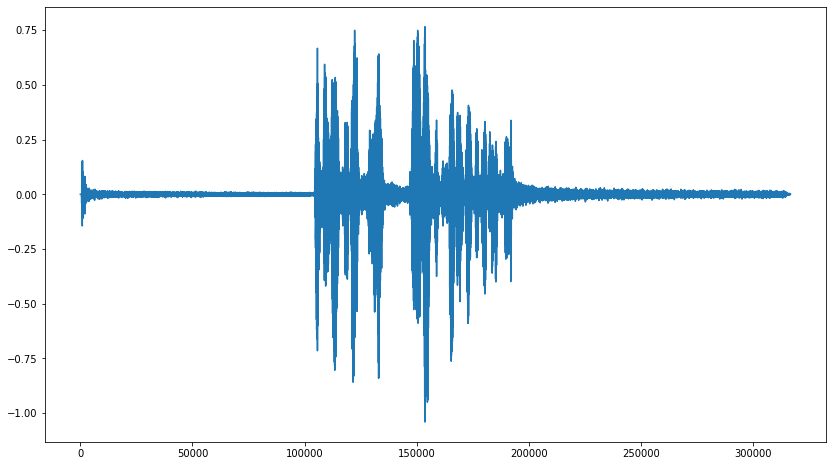

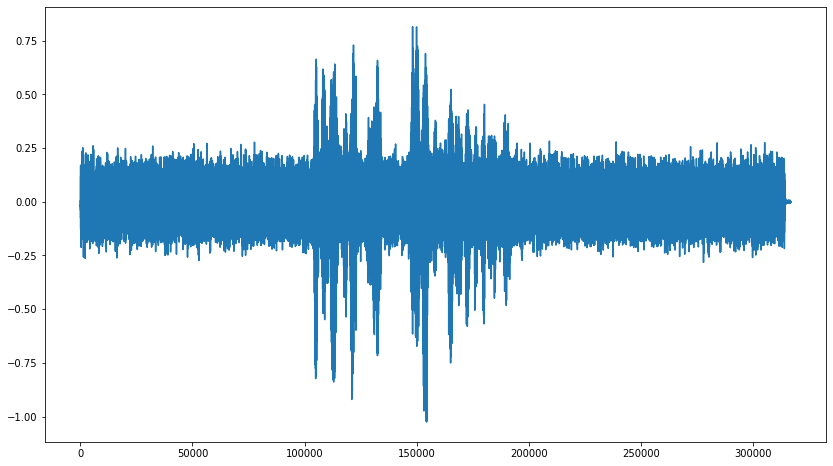

In [5]:
plt.figure(figsize=(14,8))
plt.plot(yout)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(array_data[0])
plt.show()

In [6]:
nsy = array_data[0, :]
ref = signal
sr = 16000
# enh = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office1.wav")
# enh = audioread("/home/wangwei/work/DistantSpeech/example/out2.wav")
# enh = audioread("/home/wangwei/work/nn-gev-master/nn_gev2.wav")
# enh = enh[512:]
enh = yout[frameLen:]
nsy = nsy[: len(enh)]
ref = ref[: len(enh)]

offset = 20480 # skip unconverge segment
enh = enh[offset:]
nsy = nsy[offset:]
ref = ref[offset:]

summary = {
    'ref_pesq_wb': pesq(sr, ref, nsy, 'wb'),
    'enh_pesq_wb': pesq(sr, ref, enh, 'wb'),
    'ref_pesq_nb': pesq(sr, ref, nsy, 'nb'),
    'enh_pesq_nb': pesq(sr, ref, enh, 'nb'),
    'ref_stoi': stoi(ref, nsy, sr, extended=False),
    'enh_stoi': stoi(ref, enh, sr, extended=False),
    'ref_estoi': stoi(ref, nsy, sr, extended=True),
    'enh_estoi': stoi(ref, enh, sr, extended=True),
}
for key in summary.keys():
    print('{}:{}'.format(key, summary[key]))

ref_pesq_wb:1.0748343467712402
enh_pesq_wb:1.4330074787139893
ref_pesq_nb:1.3155165910720825
enh_pesq_nb:1.9367411136627197
ref_stoi:0.7575306433585894
enh_stoi:0.8421248023461594
ref_estoi:0.5522761486614357
enh_estoi:0.7378261131328637
